<a href="https://colab.research.google.com/github/superbunny38/SKKUAI/blob/main/preprocess/GeneratingAugmentedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import re
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import normalize
import PIL.Image as Image
!pip install kornia
import kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.3 MB/s 


In [ ]:
import pandas as pd

In [ ]:
import cv2
import os
def calc_avg_mean_std(img_names, img_root, size):
    mean_sum = np.array([0., 0., 0.])
    std_sum = np.array([0., 0., 0.])
    n_images = len(img_names)
    for img_name in img_names:
        img = cv2.imread(img_root + img_name)
        img = cv2.resize(img, size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mean, std = cv2.meanStdDev(img)
        mean_sum += np.squeeze(mean)
        std_sum += np.squeeze(std)
    return (mean_sum / n_images, std_sum / n_images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
!mkdir train_data
file1 = "/content/drive/MyDrive/2022/ai_competition/train.zip"
shutil.unpack_archive(file1, "/content/train_data")

In [ ]:
train_img_root = "/content/train_data/images/"
train_img_names = os.listdir(train_img_root)

In [ ]:
train_mean, train_std = calc_avg_mean_std(train_img_names, train_img_root, (248,200))
train_mean, train_std

(array([64.28836667, 32.85761432, 31.56599267]),
 array([56.11941082, 38.43741002, 38.49034872]))

# Get Data

In [ ]:
df=pd.read_csv('/content/train_data/grade_labels.csv')

labelencoder=preprocessing.LabelEncoder()
df['Grade']=labelencoder.fit(['1++','1+','1','2','3']).transform(df['grade'])

train_len=int(len(df))
class Dataset(Dataset):

    def __init__(self, data, path, transform=None):
        self.data=data # data = csv file
        self.path=path # data directory
        self.transform=transform

    def __getitem__(self, idx):
        file_name = self.data['imname'][idx]
        img = Image.open(self.path+file_name)
        label = self.data['Grade'][idx]
        label = torch.tensor(label, dtype=torch.int64)

        if self.transform:
            data = self.transform(img)

        return data, label
    
    def __len__(self):
        return len(self.data)


train_transform=torchvision.transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize(train_mean,train_std)
    ])

whole_dataset = Dataset(df,'/content/train_data/images/',transform=train_transform)

In [ ]:
len(whole_dataset)

10000

In [ ]:
trainset, validset = torch.utils.data.random_split(whole_dataset, [9000, 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                        shuffle=True, num_workers=0)

In [ ]:
testloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                        shuffle=True, num_workers=0)

# Make Image Dataset

In [ ]:
!pip install kornia
import kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 14.7 MB/s 


In [ ]:
pytorch_transform = torchvision.transforms.Compose([
    transforms.ToTensor()])

In [ ]:
transform_kornia1 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomHorizontalFlip(p=0.8),
    kornia.augmentation.ColorJitter(0.4, 0.4, 0.4, 0, p=0.3)
    #kornia.augmentation.Normalize(train_mean, train_std)
)

In [ ]:
transform_kornia2 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomGrayscale(p=0.8),
    kornia.augmentation.RandomVerticalFlip(p=0.5)
    #kornia.augmentation.Normalize(train_mean, train_std)
)

In [ ]:
transform_kornia3 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.CenterCrop((100,100)),
    kornia.augmentation.ColorJitter(0.4, 0.4, 0.4, 0, p=0.3),
    kornia.augmentation.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio= (0.3, 3.3))
    #kornia.augmentation.Normalize(train_mean, train_std)
)

In [ ]:
transform_viz = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomHorizontalFlip(p=0.8),
    
    kornia.augmentation.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio= (0.3, 3.3))
)

# Make cutmix data

In [ ]:
transform_cutmix = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomHorizontalFlip(p=0.8),
    kornia.augmentation.RandomRotation(degrees=90.0),
)

In [ ]:
!mkdir cutmix_train

In [ ]:
train_labels = pd.read_csv('/content/train_data/grade_labels.csv')

In [ ]:
import torchvision
path_ = "/content/cutmix_train"
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_cutmix(img)
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/cutmix_train.zip" "/content/cutmix_train"

# Make cutmix data2

In [ ]:
transform_cutmix2 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomVerticalFlip(p=0.5),
    kornia.augmentation.RandomRotation(degrees=90.0),
)

In [ ]:
!mkdir cutmix_train2

In [ ]:
import torchvision
path_ = "/content/cutmix_train2"#Modify
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_cutmix2(img)#Modify
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/cutmix_train2.zip" "/content/cutmix_train2"

# Make cutmix data3

In [ ]:
transform_cutmix3 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomVerticalFlip(p=0.8),
    kornia.augmentation.CenterCrop((32,32)),
)

In [ ]:
!mkdir cutmix_train3

In [ ]:
import torchvision
path_ = "/content/cutmix_train3"#Modify
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_cutmix3(img)#Modify
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/cutmix_train3.zip" "/content/cutmix_train3"

# Make Cutmix Data4

In [ ]:
transform_cutmix4 = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomVerticalFlip(p=0.8),
    kornia.augmentation.ColorJitter(0.2, 0.3, 0.2, 0.3, p=0.5),
)

In [ ]:
!mkdir cutmix_train4

In [ ]:
import torchvision
path_ = "/content/cutmix_train4"#Modify
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_cutmix4(img)#Modify
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/cutmix_train4.zip" "/content/cutmix_train4"

# Candidate Cutmix 5

In [ ]:
pytorch_cutmix5 = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=180),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.ToTensor()])

In [ ]:
pytorch_cutmix6 = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    torchvision.transforms.ToTensor()])

In [ ]:
!mkdir trainset1

In [ ]:
train_labels = pd.read_csv('/content/train_data/grade_labels.csv')

In [ ]:
train_labels.head()

,imname,grade
0,cow_1++_4567.jpg,1++
1,cow_2_1390.jpg,2
2,cow_1++_2581.jpg,1++
3,cow_2_1689.jpg,2
4,cow_3_3287.jpg,3


In [ ]:
import torchvision
path_ = "/content/trainset1"
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_kornia1(img)
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/WAtrainset1.zip" "/content/trainset1"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/trainset1/cow_1+_3197.jpg (deflated 3%)
  adding: content/trainset1/cow_1++_2561.jpg (deflated 3%)
  adding: content/trainset1/cow_3_2526.jpg (deflated 2%)
  adding: content/trainset1/cow_1+_1364.jpg (deflated 3%)
  adding: content/trainset1/cow_1_1480.jpg (deflated 3%)
  adding: content/trainset1/cow_1_3984.jpg (deflated 3%)
  adding: content/trainset1/cow_1++_340.jpg (deflated 2%)
  adding: content/trainset1/cow_1_1801.jpg (deflated 2%)
  adding: content/trainset1/cow_1++_2935.jpg (deflated 3%)
  adding: content/trainset1/cow_1_250.jpg (deflated 2%)
  adding: content/trainset1/cow_1+_2507.jpg (deflated 2%)
  adding: content/trainset1/cow_2_3833.jpg (deflated 2%)
  adding: content/trainset1/cow_1++_3537.jpg (deflated 3%)
  adding: content/trainset1/cow_1_4556.jpg (deflated 2%)
  adding: content/trainset1/cow_1+_1894.jpg (deflated 2%)
  adding: content/trainset1/cow_1+_4069.jpg (deflated 3%)
  adding: content/trainset1/cow_1_1108.jp

In [ ]:
!mkdir real_trainset2

In [ ]:
import torchvision
path_ = "/content/real_trainset2"
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_kornia2(img)
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/real_WAtrainset2.zip" "/content/real_trainset2"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/real_trainset2/cow_1+_3197.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1++_2561.jpg (deflated 2%)
  adding: content/real_trainset2/cow_3_2526.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1+_1364.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1_1480.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1_3984.jpg (deflated 4%)
  adding: content/real_trainset2/cow_1++_340.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1_1801.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1++_2935.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1_250.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1+_2507.jpg (deflated 2%)
  adding: content/real_trainset2/cow_2_3833.jpg (deflated 2%)
  adding: content/real_trainset2/cow_1++_3537.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1_4556.jpg (deflated 3%)
  adding: content/real_trainset2/cow_1+_1894.jpg (deflated 2%)
  adding: content/real_t

In [ ]:
!mkdir trainset3

In [ ]:
import torchvision
path_ = "/content/trainset3"
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_kornia3(img)
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
!zip -r "/content/drive/MyDrive/2022/ai_competition/WAtrainset3.zip" "/content/trainset3"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/trainset3/cow_1+_3197.jpg (deflated 5%)
  adding: content/trainset3/cow_1++_2561.jpg (deflated 4%)
  adding: content/trainset3/cow_3_2526.jpg (deflated 5%)
  adding: content/trainset3/cow_1+_1364.jpg (deflated 5%)
  adding: content/trainset3/cow_1_1480.jpg (deflated 5%)
  adding: content/trainset3/cow_1_3984.jpg (deflated 4%)
  adding: content/trainset3/cow_1++_340.jpg (deflated 5%)
  adding: content/trainset3/cow_1_1801.jpg (deflated 4%)
  adding: content/trainset3/cow_1++_2935.jpg (deflated 5%)
  adding: content/trainset3/cow_1_250.jpg (deflated 4%)
  adding: content/trainset3/cow_1+_2507.jpg (deflated 3%)
  adding: content/trainset3/cow_2_3833.jpg (deflated 4%)
  adding: content/trainset3/cow_1++_3537.jpg (deflated 4%)
  adding: content/trainset3/cow_1_4556.jpg (deflated 5%)
  adding: content/trainset3/cow_1+_1894.jpg (deflated 4%)
  adding: content/trainset3/cow_1+_4069.jpg (deflated 5%)
  adding: content/trainset3/cow_1_1108.jp

# 데이터 확인

In [ ]:
!mkdir viz_train_real

In [ ]:
import torchvision
path_ = "/content/viz_train_real"
for label in train_labels['imname']:
  img = Image.open('/content/train_data/images/'+label)
  img = pytorch_transform(img)
  img_tensor = transform_viz(img)
  torchvision.utils.save_image(img_tensor, os.path.join(path_, f'{label}') )

In [ ]:
train_img_root = "/content/trainset1"
train_img_names = os.listdir(train_img_root)

In [ ]:
len(train_img_names)

10000

In [ ]:
train_img_root = "/content/real_trainset2"
train_img_names = os.listdir(train_img_root)
len(train_img_names)

10000

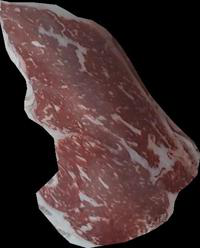

In [ ]:
from PIL import Image
img = Image.open("/content/train_data/images/"+train_labels['imname'][0])
img

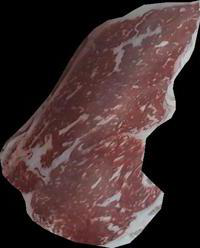

In [ ]:
from PIL import Image
img = Image.open("/content/trainset1/"+train_labels['imname'][0])
img

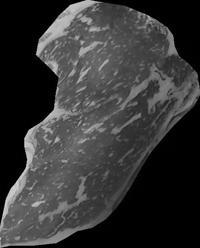

In [ ]:
from PIL import Image
img = Image.open("/content/real_trainset2/"+train_labels['imname'][0])
img

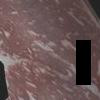

In [ ]:
from PIL import Image
img = Image.open("/content/trainset3/"+train_labels['imname'][0])
img

# Cutmix 데이터 확인

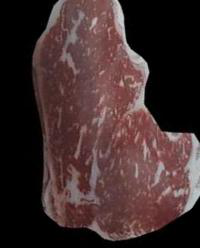

In [ ]:
from PIL import Image
img = Image.open("/content/cutmix_train/"+train_labels['imname'][0])
img

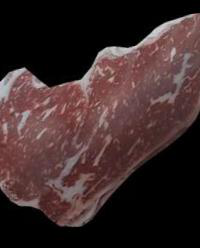

In [ ]:
from PIL import Image
img = Image.open("/content/cutmix_train2/"+train_labels['imname'][0])
img

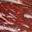

In [ ]:
from PIL import Image
img = Image.open("/content/cutmix_train3/"+train_labels['imname'][3])
img

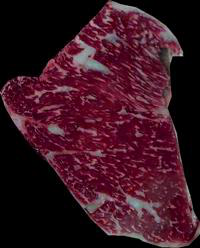

In [ ]:
from PIL import Image
img = Image.open("/content/cutmix_train4/"+train_labels['imname'][0])
img